In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from collections import Counter

In [2]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [3]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):
    
    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [4]:
def get_cluster_dfs(df, cluster):
    return[df[cluster == i] for i in np.unique(cluster)]

In [5]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [201]:
aggr = aggregate_by_label(df, 'genre', 0)

In [276]:
tfidf = TfidfVectorizer(
    #stop_words=get_stop_words('de'),
    max_features=100)

X = tfidf.fit_transform(aggr.text)
X = X.todense()

In [277]:
Xr = UMAP(n_components=2, n_neighbors=20).fit_transform(X)
#Xr = PCA(n_components=2).fit_transform(X)

In [278]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

In [279]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0            Drama
 1           Comedy
 6           Horror
 11     Documentary
 13        Thriller
 18          Action
 30          Family
 64           Crime
 92       Adventure
 108        Western
 112         Sci-Fi
 124        Romance
 132        Fantasy
 161            War
 183      Animation
 287          Music
 329        Musical
 338      Biography
 Name: label, dtype: object,
 18)

In [343]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

#clu = GaussianMixture(n_components=n_single_labels)
#clu = DBSCAN(eps=.55, min_samples=10)
clu = KMeans(n_clusters=n_single_labels)
Xpca = UMAP(n_components=50).fit_transform(X)

cluster = clu.fit_predict(Xpca)
#probs = clu.predict_proba(Xpca)

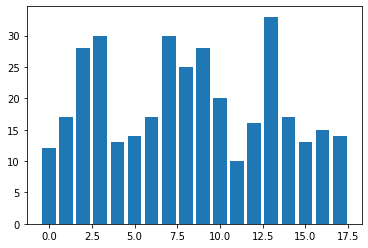

In [344]:
cluster_counter = Counter(cluster)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [345]:
cluster

array([ 7,  5,  7,  7,  7,  1, 14,  8,  8, 15, 13,  3,  8,  8, 15, 12,  4,
        9,  4, 10,  2, 16,  6, 17, 15,  8, 14, 17,  9,  4, 13, 13, 12,  6,
       17,  9,  8,  9, 15, 12,  7,  0, 14, 12, 17,  5, 17,  6, 13,  8, 17,
        6,  7,  7,  8,  8, 13,  2, 14,  8,  9, 16,  2, 13,  4,  9,  8, 12,
        8,  2, 14,  6,  6,  5, 14,  1, 14,  3,  4,  7,  6,  6,  1,  7, 13,
        7, 11,  7, 17, 16,  8,  9,  9, 10,  2,  5, 15,  8, 16, 13,  8,  4,
       17, 17, 13,  1,  6,  4, 11, 10,  7, 12, 16,  0,  3,  9,  0,  3, 10,
        8,  3, 15,  2,  8,  1,  3,  7, 10,  9, 17,  2, 12, 10, 17,  5, 13,
       13, 15, 13,  0,  9, 14,  8,  4,  0,  8, 11,  2,  7, 17,  1, 16,  8,
       10, 15, 13,  3,  8,  5, 10, 16, 12,  4,  0, 17, 10, 13,  4,  9,  1,
       14, 15,  8, 10,  0, 12,  2, 11,  6, 13,  7,  2,  3, 13,  0, 16,  7,
        9,  3, 13,  9,  3,  4,  8, 10, 15,  9, 12, 13,  7, 11, 13,  2, 10,
        2, 16,  6,  3,  5, 17, 10, 14, 13,  9,  7,  8,  3, 14,  1, 11, 16,
        3, 15, 16,  2, 15

In [346]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(cluster)))


fig.show()

In [347]:
dfs = get_cluster_dfs(aggr, cluster)

In [348]:
for cluster_df in dfs:
    print(cluster_df.label)
    print(f'Total number of movies in cluster => {cluster_df.n_texts.sum()}')
    print(f'Total number of tokens in cluster => {cluster_df.n_tokens.sum()}')
    print('#'*60)

41       Action,Biography,Drama
113       Biography,Drama,Sport
116     Action,Animation,Sci-Fi
139         Biography,Drama,War
144       Drama,Fantasy,Mystery
163      Animation,Comedy,Drama
174          Drama,Thriller,War
184            Action,Drama,War
229            Animation,Sci-Fi
244    Action,Adventure,Western
251            Adventure,Sci-Fi
341         Action,Comedy,Music
Name: label, dtype: object
Total number of movies in cluster => 48
Total number of tokens in cluster => 404923
############################################################
5               Comedy,Romance
75                 Drama,Music
82         Comedy,Drama,Family
105      Comedy,Horror,Romance
124                    Romance
150       Drama,Horror,Romance
169      Comedy,Family,Romance
218            Animation,Drama
269        Comedy,Crime,Horror
278    Biography,Drama,Fantasy
287                      Music
311        Crime,Drama,Fantasy
336       Drama,Music,Thriller
340               Thriller,War
343     Co